# **Univariate LSTM Models**

In [1]:
#We start by importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Now, we import the dataset. In this case, we don't need to set the date as index, and parse dates, as we have been doing for ARIMA models. We can just import the dataset as it is.
df = pd.read_csv('Solar+Data+Set.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8760 non-null   object 
 1   Solar Ir   8760 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.0+ KB


In [4]:
df.head()

,Date,Solar Ir
0,1/1/2019 0:00,0.0
1,1/1/2019 1:00,0.0
2,1/1/2019 2:00,0.0
3,1/1/2019 3:00,0.0
4,1/1/2019 4:00,0.0


## **1. Preprocessing**

In [5]:
#As always, it is really important to deal with missing values.
df.isnull().sum()

Date         0
Solar Ir     0
dtype: int64

In [6]:
#We don't have any missing values, so we can proceed to the next step. Despite that, we will use the dropna function as a good practice, so we can use it in other cases.
df.dropna(inplace=True)

In [7]:
#Now, let's split data into train and set
train = df.iloc[:8712,1:2].values #We are just using the second column, which is the energy generation. For LSTM date column is not necessary. Also, we will use values method to convert the dataframe into a numpy array.
test = df.iloc[8712:,1:2].values

In [8]:
print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (8712, 1)
Test Shape: (48, 1)


In [9]:
#Only part missing is feature scaling. In this example we just have one variable, so normalizing is not neccessary. However, we will do it as a good practice. Sometimes, the difference between values, despite just having one column, can be huge, so it is always a good idea to normalize.
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1)) #We create an object of the MinMaxScaler class, and we set the feature range from 0 to 1
train_scaled = sc.fit_transform(train) #We fit and transform the train set´
test_scaled = sc.fit_transform(test) #We transform the test set

Before continuing our model, we have to understand a concept: Look Back Window or Period. This is the number of previous time steps to use as input variables to predict the next time period. In the training process, imagine that I have a look back window of 4. I will use t1, t2, t3 and t4 to predict t5. Then, I will use t2, t3, t4 and t5 to predict t6 and so on. That's how our model is going to be trained.

The window size is a parameter that we are going to give to our model. Which window size should we use? It depends on each problem. As general rule, we want to consider at least one seasonality period. For example, if we have daily data and we know that there is a weekly seasonality, we should use a window size of 7. If we have monthly data and we know that there is a yearly seasonality, we should use a window size of 12.

We can increase windows size and most of the time it will increase model accuracy but also, it will increase the training time. So, we have to find a balance between accuracy and training time.



In [10]:
#We need to create empty lists as we are going to use for loop to append the values
X_train = []
y_train = []

#We select windows size as 24, as we have 24 hours seasonality
WS = 24

In [11]:
#Now, we create the for loop for creating our X_train and y_train
for i in range(WS, len(train_scaled)):
    X_train.append(train_scaled[i-WS:i,0:1]) #We are using the append method and we are saying, go to train_scaled and select the values from i-WS to i, and select the first column. With that, we would have different batches of 24, 24... So, first batch is the first 24 hours, then the second batch is from 1 to 25, and so on.
    y_train.append(train_scaled[i,0]) #For the y_train we are doing pretty much the same thing but we are just selecting the next value, so if first batch covers from 0 to 23, the y_train will be 24, and so on.

#Finally we have to convert the X_train and y_train into numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

## **2. Developing a LSTM Model**

In [12]:
#First, we will import the necessary libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [13]:
Model_P = Sequential() #We create an object of the Sequential class

In [14]:
#Now, we have to create our layers inside the model created
Model_P.add(LSTM(units=60, return_sequences=True, input_shape = (X_train.shape[1],1))) #The parameters here have been selected kind of randomly. What we should do in next iterations is applying hyperparameter tuning to find the best parameters. The input shape has to be defined on our first layer. This first layer is responsible for receiving the input values

(X_train.shape[1],1). The last one is indicating the number of dimensions. Now, we just have one dimension, so it will be one. If we had more than one dimension, we would have to change this parameter.

In [15]:
X_train.shape[1]

24

In [16]:
#Now, prior to create the next layer, we will add the dropout regularization to avoid overfitting. Dropout works dropping some of neurons randomly
Model_P.add(Dropout(0.2)) #By indicating 0.2, we are saying that 20% of the neurons will be dropped

In [17]:
#Now, we go to the next layer. It will be as the 1st one, but we don't need to specify the input shape. We will also add a dropout layer
Model_P.add(LSTM(units=60, return_sequences=True))
Model_P.add(Dropout(0.2))

In [18]:
#We add a 3rd layer
Model_P.add(LSTM(units=60, return_sequences=True))
Model_P.add(Dropout(0.2))

In [19]:
#Finally, we add a 4th layer. This time we won't return sequences, as we are not going to add more LSTM layers
Model_P.add(LSTM(units=60))
Model_P.add(Dropout(0.2))

In [20]:
#Now, we add the output layer
Model_P.add(Dense(units=1)) #We just need to specify the number of units, which is 1, as we are just predicting one value

In [21]:
#Now, we need to compile the model
Model_P.compile(optimizer='adam', loss='mean_squared_error') #When compiling, we need to specify the optimizer and the loss function. In this case, we are using adam optimizer (as it is good for time series), and mean squared error as loss function

In [22]:
#Now, we will fit our model
Model_P.fit(X_train, y_train, epochs = 30, batch_size= 32) #Epochs mean number of iterations. We have to play with this parameter to find the best number of epochs. Batch size is the number of observations after which we want to update the weights. We can modify this parameter to find the best one.

Epoch 1/30
272/272 [==============================] - 14s 30ms/step - loss: 0.0251
Epoch 2/30
272/272 [==============================] - 8s 29ms/step - loss: 0.0073
Epoch 3/30
272/272 [==============================] - 8s 31ms/step - loss: 0.0047
Epoch 4/30
272/272 [==============================] - 9s 33ms/step - loss: 0.0033
Epoch 5/30
272/272 [==============================] - 9s 34ms/step - loss: 0.0027
Epoch 6/30
272/272 [==============================] - 9s 34ms/step - loss: 0.0024
Epoch 7/30
272/272 [==============================] - 10s 35ms/step - loss: 0.0020
Epoch 8/30
272/272 [==============================] - 10s 36ms/step - loss: 0.0018
Epoch 9/30
272/272 [==============================] - 11s 40ms/step - loss: 0.0017
Epoch 10/30
272/272 [==============================] - 11s 39ms/step - loss: 0.0015
Epoch 11/30
272/272 [==============================] - 10s 37ms/step - loss: 0.0016
Epoch 12/30
272/272 [==============================] - 10s 37ms/step - loss: 0.0015
Epoch 

Despite having a really low loss, it is even possible that in the test set our model is not able to predict the values correctly, so we have to be aware of that, and further analysis should be done. To avoid running the model several times, we shall save the model and load it later.

To find the right epoch number, we can plot the result of the model and see when we are not increasing the accuracy anymore, or when computationally capability is not worth the accuracy increase.

In [23]:
Model_P.save('LSTM_Univariate.keras')

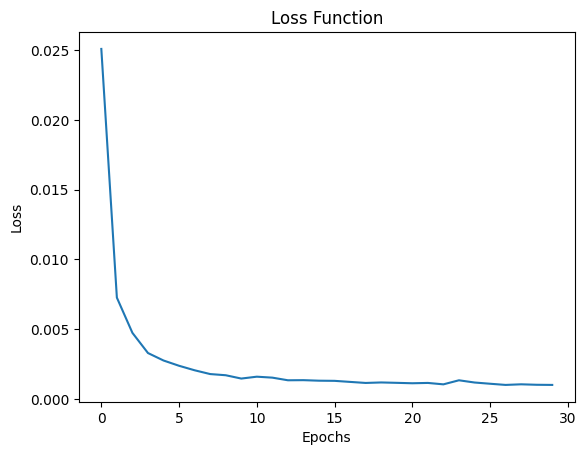

In [24]:
plt.plot(range(len(Model_P.history.history['loss'])), Model_P.history.history['loss']) #We plot the loss function to see how it is evolving
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

By looking at the previous graph we can see that after 15, the accuracy is not increasing anymore. So, we can use 15 as the epoch number, if the training time is too long now. We have also to be careful of overfitting, while picking the number of epochs

In [25]:
#Now, if we want to start from here without having to run all the code, we can just load the model
from keras.models import load_model
Model_P = load_model('LSTM_Univariate.keras')

What do we want to do now for predicting or testing our model? From the training part, we broke down our dataset into different batches of 24. But, for the testing, we need also to have the same structure, as our model is expecting to receive batches of 24, and then predicting the next value. Then, in order to test our model, we need to create such structure that generates batches of 24, and then we can predict the next value.

So, imagine that we have batches of 4. We have t1, t2, t3, t4. We apply the model and then we get t5. Then, we use that t5 value predicted by our model in the next batch (t2, t3, t4, t5) to predict t6. And so on. That's how we are going to test our model or to use our model for predicting new values.

## **3. Testing the LSTM Model**

In [30]:
#First, we need to create our test set, something like we did for the train set
#We create empty lists
prediction_test = []

Batch_one = train_scaled[-WS:] #We select the last 24 values (or WS is 24) of the train set
Batch_new = Batch_one.reshape(1,WS,1) #We reshape the batch to be able to use it in the model. 1 is the number of batches, WS is the window size, and 1 is the number of features

In [31]:
#Now, we create a for loop to predict the values
for i in range(len(test_scaled)): #Here we are applying the length of the test set, as we want to predict all the values in test set. If we wanted to predict further values, we would have to change this parameter
    First_Pred = Model_P.predict(Batch_new)[0] #We predict the first value
    prediction_test.append(First_Pred) #We append the  predicted value to the list prediction_test
    Batch_new = np.append(Batch_new[:,1:,:],[[First_Pred]],axis=1) #From Barch Newm from second dimension, I say, start from 1, so I don't want the first value. Then, append to barch new the prediction that we have made (First Pred). Thanks to this, Batch_new will be update, containing always the last 23 values of the previous batch, and the new predicted value

1/1 [==============================] - 0s 20ms/step


In [34]:
prediction_test

array([[0.00475112],
       [0.00501415],
       [0.00557414],
       [0.00635964],
       [0.00729591],
       [0.00833431],
       [0.00960204],
       [0.01409784],
       [0.1491864 ],
       [0.5533273 ],
       [0.78658605],
       [0.88186467],
       [0.8935415 ],
       [0.83034796],
       [0.6858057 ],
       [0.41958427],
       [0.01335301],
       [0.01263949],
       [0.01148131],
       [0.00997764],
       [0.00846988],
       [0.00727299],
       [0.00643992],
       [0.00590181],
       [0.00564411],
       [0.00553775],
       [0.00589895],
       [0.00660267],
       [0.00752851],
       [0.00858983],
       [0.00998616],
       [0.01834337],
       [0.21129756],
       [0.6089419 ],
       [0.8206846 ],
       [0.89436316],
       [0.8943328 ],
       [0.8228221 ],
       [0.6760487 ],
       [0.42111623],
       [0.06241152],
       [0.05167054],
       [0.03962325],
       [0.02787921],
       [0.01828738],
       [0.01184267],
       [0.00818104],
       [0.006

In [33]:
#We have now the prediction test. We need it as a numpy array
prediction_test = np.array(prediction_test)

In [35]:
type(prediction_test)

numpy.ndarray

In [36]:
#Now, we want to inverse transform the prediction test, as we had normalized data
prediction_test = sc.inverse_transform(prediction_test) #We inverse transform the prediction test, as we had normalized it

Now, we have been able to predict. What we have to do know is check how our model has been working.

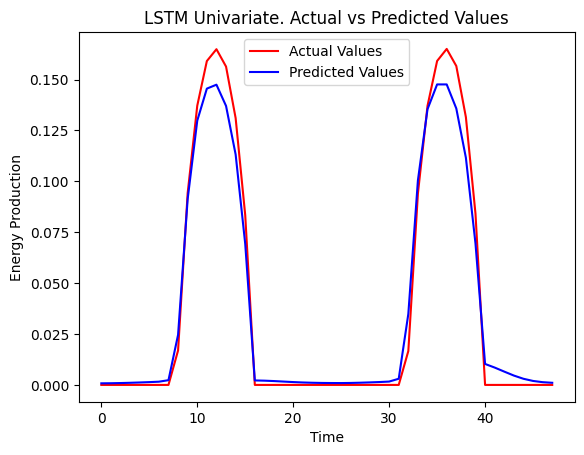

In [38]:
plt.plot(test, color='red', label='Actual Values')
plt.plot(prediction_test, color='blue', label='Predicted Values')
plt.title('LSTM Univariate. Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Energy Production')
plt.legend()

As we can see, the model is predicting quite well. We can do some hyperparameter tuning to improve the model, changing epochs, neurons, batch size, optimizer, etc.

In [39]:
import math
from sklearn.metrics import mean_squared_error

RMSE = math.sqrt(mean_squared_error(test, prediction_test))
print('RMSE:', RMSE)

RMSE: 0.008749494573697548


In [40]:
from sklearn.metrics import r2_score

R2 = r2_score(test, prediction_test)

print('R2:', R2)

R2: 0.9800563048957386


Our R squared is 98%, so this is almost perfect, and the RMSE is really low, so it seems like the model has done a really good job

By increasing the number inside range in the loop, we can predict further in the future. For example, if we want to predict 24 hours in the future, we can change the range to 24. If we want to predict 7 days in the future, we can change the range to 168.